In [1]:
#Installing required libraries
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

(16000,) 16000


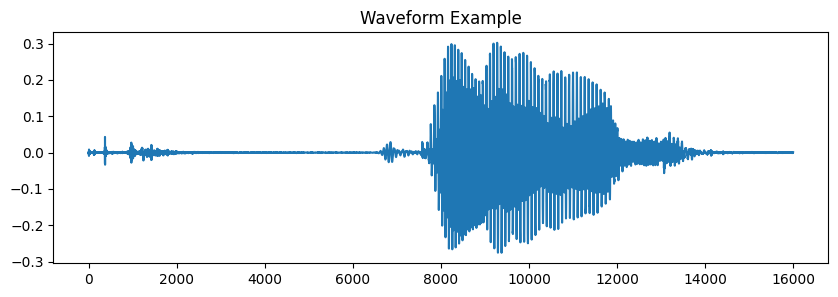

In [17]:
#Load multiple audio files + Extract MFCC Features
file_path = "../data/bird/0a7c2a8d_nohash_0.wav"

y, sr = librosa.load(file_path, sr=16000)
print(y.shape, sr)

plt.figure(figsize=(10,3))
plt.plot(y)
plt.title("Waveform Example")
plt.show()

In [30]:
def extract_features(file_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, time)
    mfcc = mfcc.T  # now shape = (time, n_mfcc)
    return mfcc

In [31]:
data_dir = "../data"

X = []
y = []

class_labels = os.listdir(data_dir)

for label in class_labels:
    class_path = os.path.join(data_dir, label)

    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        if file.endswith(".wav"):
            file_path = os.path.join(class_path, file)
            features = extract_features(file_path)
            X.append(features)
            y.append(label)

print("Loaded files:", len(X))


Loaded files: 610


In [32]:
max_len = max([f.shape[0] for f in X])  # longest MFCC time length
print("Max sequence length:", max_len)

X_padded = pad_sequences(
    X,
    maxlen=max_len,
    padding='post',
    dtype='float32'
)

X_padded = np.array(X_padded)
y = np.array(y)

print("Feature matrix:", X_padded.shape)
print("Labels:", y.shape)


Max sequence length: 32
Feature matrix: (610, 32, 40)
Labels: (610,)
